In [22]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os
if os.getcwd().split("/")[-1] != 'BENDR-XAI': os.chdir("../")

from scipy.stats import ttest_ind, mannwhitneyu
import datetime
import seaborn as sns 
import pandas as pd

In [184]:
def is_random_concept(concept, random_counterpart=None, random_concepts=None):
    if random_counterpart:
        return random_counterpart == concept

    elif random_concepts:
        return concept in random_concepts

    else:
        return 'random500_' in concept

def summarize_results(results):
    summary = {}
    random_results = {}

    for result in results:
        concept = result['cav_concept']
        bottleneck = result['bottleneck']

        if concept not in summary:
            summary[concept] = {}
        if bottleneck not in summary[concept]:
            summary[concept][bottleneck] = []

        summary[concept][bottleneck].append(result)

        if is_random_concept(concept):
            if bottleneck not in random_results:
                random_results[bottleneck] = []

            random_results[bottleneck].append(result['i_up'])

    return summary, random_results

def get_tcav_results(summary, random_results, min_p_val=0.05):
    columns = ['concept', 'bottleneck', 'score', 'random_score', 'p_value', 'significant']
    results_df = pd.DataFrame(columns=columns)

    for concept in summary:
        if not is_random_concept(concept):
            for bottleneck in summary[concept]:
                scores = [item['i_up'] for item in summary[concept][bottleneck]]
                _, p_val = mannwhitneyu(random_results[bottleneck], scores)
                significant = p_val <= min_p_val
                data = {'concept': concept, 'bottleneck': bottleneck,
                        'score': np.mean(scores), 'random_score': np.mean(random_results[bottleneck]),
                        'p_value': p_val, 'significant': significant}
                results_df = pd.concat([results_df, pd.DataFrame(data, index=[0])], ignore_index=True)

    return results_df

def merge_left_right_results(df):
    output_df = pd.DataFrame(columns=['concept', 'bottleneck', 'lh_score', 'rh_score', 'random_score', 'lh_p', 'rh_p'])
    
    assert all([concept.endswith('-lh') or concept.endswith('-rh') for concept in df['concept'].unique()])

    for row in df[df['concept'].str.endswith('-lh')].itertuples():
        row_dict = row._asdict()
        concept_name = row_dict['concept'][:-3]
        bottleneck = row_dict['bottleneck']
        lh_score = row_dict['score']
        lh_p = row_dict['p_value']
        lh_random_score = row_dict['random_score']

        rh_row = df[(df['concept'] == concept_name + '-rh') & (df['bottleneck'] == bottleneck)]
        assert len(rh_row) == 1
        rh_score = rh_row['score'].values[0]
        rh_p = rh_row['p_value'].values[0]
        rh_random_score = rh_row['random_score'].values[0]
    
        assert lh_random_score == rh_random_score

        data = {'concept': concept_name, 'bottleneck': bottleneck,
                'lh_score': lh_score, 'rh_score': rh_score, 'random_score': lh_random_score,
                'lh_p': lh_p, 'rh_p': rh_p}
        
        output_df = pd.concat([output_df, pd.DataFrame(data, index=[0])], ignore_index=True)

    return output_df

def move_left_right_to_colomn(df):
    columns = ['concept', 'bottleneck', 'score', 'random_score', 'p_value', 'significant', 'hemi']
    output_df = pd.DataFrame(columns=columns)
    
    assert all([concept.endswith('-lh') or concept.endswith('-rh') for concept in df['concept'].unique()])
    
    for row in df.itertuples():
        row_dict = row._asdict()
        
        concept_name = row_dict['concept'][:-3]
        bottleneck = row_dict['bottleneck']
        score = row_dict['score']
        random_score = row_dict['random_score']
        p_value = row_dict['p_value']
        significant = row_dict['significant']
        hemi = row_dict['concept'][-2:]       
        
        data = {'concept': concept_name, 'bottleneck': bottleneck,
                'score': score, 'random_score': random_score,
                'p_value': p_value, 'significant': significant, 'hemi': hemi}
        
        output_df = pd.concat([output_df, pd.DataFrame(data, index=[0])], ignore_index=True)
        
    return output_df
                

In [185]:
result_path = 'data/tcav_results_0502223524939809_TUH_clean_all_divide_Falsesigma_Falseabs_100.0_210702_010523_25.pkl'
with open(result_path, 'rb') as f:
    results = pickle.load(f)
    
results = sorted(results, key=lambda k: k['cav_concept'])

result_summary, random_i_ups = summarize_results(results)
df = get_tcav_results(result_summary, random_i_ups)
df_merge = merge_left_right_results(df)
df_extra = move_left_right_to_colomn(df)

In [198]:
df_merge

,concept,bottleneck,lh_score,rh_score,random_score,lh_p,rh_p
0,Alpha_Dorsal Stream Visual Cortex,encoder,0.4272,0.4768,0.490600,4.054264e-01,7.200753e-01
1,Alpha_Dorsal Stream Visual Cortex,enc_augment,0.5952,0.2144,0.459667,1.109881e-01,1.090416e-02
2,Alpha_Dorsal Stream Visual Cortex,summarizer,0.8224,0.5744,0.488400,1.129300e-04,2.975546e-01
3,Alpha_Dorsal Stream Visual Cortex,extended_classifier,0.1600,0.1600,0.486667,1.365155e-03,1.365155e-03
4,Alpha_Dorsal Stream Visual Cortex,classifier,0.5200,0.1600,0.495000,8.071471e-01,1.033447e-03
5,Alpha_Early Visual Cortex,encoder,0.5872,0.5968,0.490600,1.985903e-01,1.133829e-01
6,Alpha_Early Visual Cortex,enc_augment,0.1920,0.4768,0.459667,4.368603e-04,6.133420e-01
7,Alpha_Early Visual Cortex,summarizer,0.1072,0.4912,0.488400,1.754733e-05,7.776437e-01
8,Alpha_Early Visual Cortex,extended_classifier,0.0000,0.6800,0.486667,1.804636e-06,5.846140e-02
9,Alpha_Early Visual Cortex,classifier,0.2400,0.5600,0.495000,1.252555e-02,5.249640e-01


In [218]:
np.linspace(0, 10, 5)

array([ 0. ,  2.5,  5. ,  7.5, 10. ])

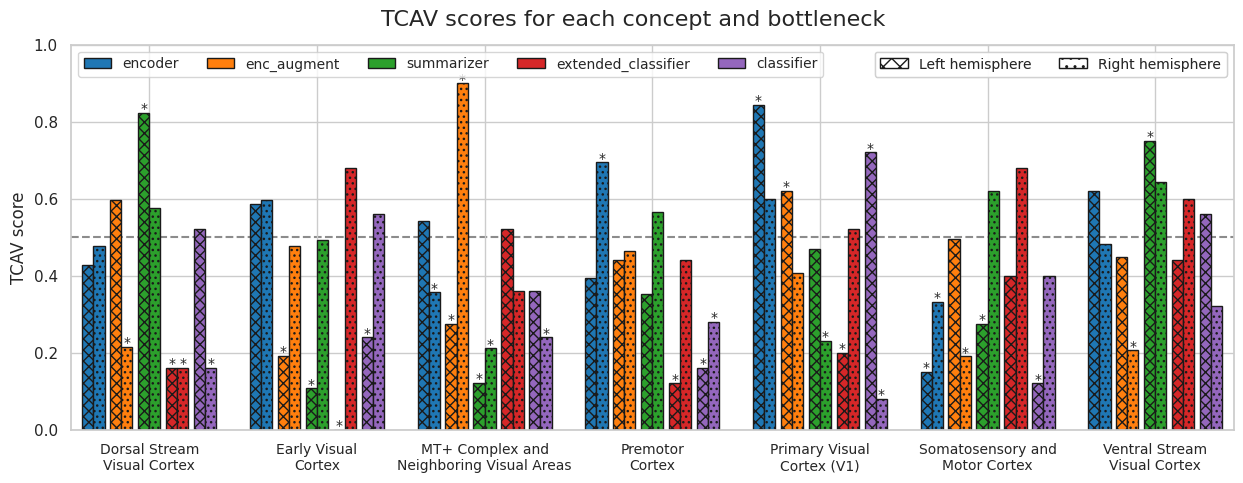

In [322]:
from matplotlib.patches import Patch

def format_string(s):
    space_idxs = [i for i, c in enumerate(s) if c == ' ']
    return s[:space_idxs[len(space_idxs)//2]] + '\n' + s[space_idxs[len(space_idxs)//2]+1:]
    

tab10 = plt.get_cmap('tab10').colors

fig, ax = plt.subplots(figsize=(15, 5))

positions = np.array([ 0. ,  2.5,  5. ,  7.5, 10. ])
min_pos = -0.5
max_pos = float('-inf')

xticks = []

# Hline at 0.5 behind bars
ax.axhline(0.5, color='k', linestyle='--', zorder=-1, alpha=0.5)

for i, concept in enumerate(df_merge['concept'].unique()):
    for j, bottleneck in enumerate(df_merge[df_merge['concept'] == concept]['bottleneck']):
        x = 15*i + positions[j]
        
        data = df_merge[(df_merge['concept'] == concept) & (df_merge['bottleneck'] == bottleneck)]
        
        y1 = data['lh_score'].values[0]
        y2 = data['rh_score'].values[0]
        
        # Make two bars side by side with y1 and y2 values in different patterns
        ax.bar(x - 0.5, y1, width=1, color=tab10[j], edgecolor='k', hatch='xxx')
        ax.bar(x + 0.5, y2, width=1, color=tab10[j], edgecolor='k', hatch='...')
        
        lh_p = data['lh_p'].values[0]
        rh_p = data['rh_p'].values[0]
        
        # Add '*' above the bar if the score is significant
        if lh_p < 0.05:
            ax.text(x - 0.5, y1, '*', fontsize=10, horizontalalignment='center')
        if rh_p < 0.05:
            ax.text(x + 0.5, y2, '*', fontsize=10, horizontalalignment='center')        
        
        max_pos = max(max_pos, x + 0.5)        
        
    xticks.append(np.mean(15*i + positions))
    
xtickslabels = df_merge['concept'].unique()
xtickslabels = [format_string(label.replace('Alpha_', '')) for label in xtickslabels]
ax.set_xticks(xticks)
ax.set_xticklabels(xtickslabels, rotation=0, fontsize=10)

# Make legend with colors and bottlenecks names. Make it one row
legend_elements = [Patch(facecolor=tab10[i], edgecolor='k', label=bottleneck) for i, bottleneck in enumerate(df_merge['bottleneck'].unique())]
legend1 = plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0, 1), ncol=5, fontsize=10)

# Add an extra legend without removing the previous one
legend_elements = [Patch(facecolor='w', edgecolor='k', hatch='xx', label='Left hemisphere'),
                     Patch(facecolor='w', edgecolor='k', hatch='..', label='Right hemisphere')]
legend2 = plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1, 1), ncol=5, fontsize=10)

# Add both legends to the plot
ax.add_artist(legend1)
ax.add_artist(legend2)

ax.set_ylim(0, 1)
ax.set_ylabel('TCAV score', fontsize=12)

ax.set_xlim(min_pos - 1.5, max_pos + 1.5)

plt.suptitle('TCAV scores for each concept and bottleneck', fontsize=16, y=0.95)

#plt.tight_layout()
plt.show()
